# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Split the training set into training and validation sets
* Extract gallery and probe arrays from the validation set
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [1]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras

import time

import numpy.matlib
import scipy

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50



# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# Split the training set into train and validation, with a disjoint set of IDs in each
#   X:         X data to split
#   Y:         Y data to split, corresponds to X
#   id_cutoff: Any IDs equal or smaller than this will be train, the rest will be in validation
#
#   returns:   numpy arrays for the training and validation sets, which contain mutually exclusise sets
#              of subjects
#
def split_validation(X, Y, id_cutoff = 250):

    train_X = X[Y <= id_cutoff, :]
    train_Y = Y[Y <= id_cutoff]

    val_X = X[Y > id_cutoff, :]
    val_Y = Y[Y > id_cutoff]

    return train_X, train_Y, val_X, val_Y

# Extract gallery and probe sets from a given chunk of data. Gallery and probe will contain one sample each
# for each subject, with only the first and second images for each subject used, and the rest discarded.
#   X:         X data to split
#   Y:         Y data to split, corresponds to X
#
#   returns:   numpy arrays containing gallery and probe sets corresponding to the input data. Gallery and
#              probe will both contain one image of each subject. Any subjects with fewer than two images 
#              will be discarded
#
def sample_gallery_and_probe(X, Y):
    
    # storage
    gallery_X = []
    gallery_Y = []
    probe_X = []
    probe_Y = []

    # find unique IDs
    unique_ids = np.unique(Y)
    # loop through unique IDs
    for i in unique_ids:
        # pull out samples for the current ID
        samples = X[Y == i, :]
        # need at least two samples for use the ID
        if samples.shape[0] >= 2:
            # first sample for a subject stored in the gallery
            gallery_X.append(samples[0, :])
            gallery_Y.append(i)
            # second sample stored in the probe
            probe_X.append(samples[1, :])
            probe_Y.append(i)
            # any other images for the subject are ignored

    # return extracted data
    return np.array(gallery_X), np.array(gallery_Y), np.array(probe_X), np.array(probe_Y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))
    # split validation data
    train_X, train_Y, val_X, val_Y = split_validation(train_X, train_Y)

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L2 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L2 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l2_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L2 distance here. Note that L2
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=2)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      

def compute_cmc(probe, probe_labels, gallery, gallery_labels, top_k=(1, 5, 10)):
    dists = pairwise_distances(probe, gallery, metric='euclidean')
    sorted_idxs = np.argsort(dists, axis=1)  # ascending order (closest first)
    matches = (gallery_labels[sorted_idxs] == probe_labels[:, None])
    
    cmc = np.zeros(len(gallery_labels))
    top_n_acc = {}

    for i in range(len(probe_labels)):
        match = matches[i]
        rank = np.where(match)[0][0]  # first correct match
        cmc[rank:] += 1

    cmc = cmc / len(probe_labels)
    
    for k in top_k:
        top_n_acc[f"Top-{k}"] = np.mean(np.any(matches[:, :k], axis=1))

    return cmc, top_n_acc














E0000 00:00:1746394083.490046    1209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746394083.552543    1209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746394084.083488    1209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746394084.083517    1209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746394084.083519    1209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746394084.083520    1209 computation_placer.cc:177] computation placer already registered. Please check linka

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.

### Data Loading

This will load the data, pulling out the training set and validation set, and gallery and probe testing sets. Note that to ready the validation set for the target identification function, you still need to call the `sample_gallery_and_probe` function (see below for details).

Note the size of the datasets here, and the number of unique subjects in each:
* The training set contains images for 250 unique IDs, with multiple images for each.
* The validation set contains a different 50 identities, with multiple images for each.
* The testing set is the gallery and probe sets combined:
  * The gallery set contains 1 image for another 301 unique IDs (totally separate to those in the training and validation sets) 
  * The probe set contains another single image for the same 301 subjets as the gallery set.

(4711, 128, 64, 3)
(4711,)
(1222, 128, 64, 3)
(1222,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


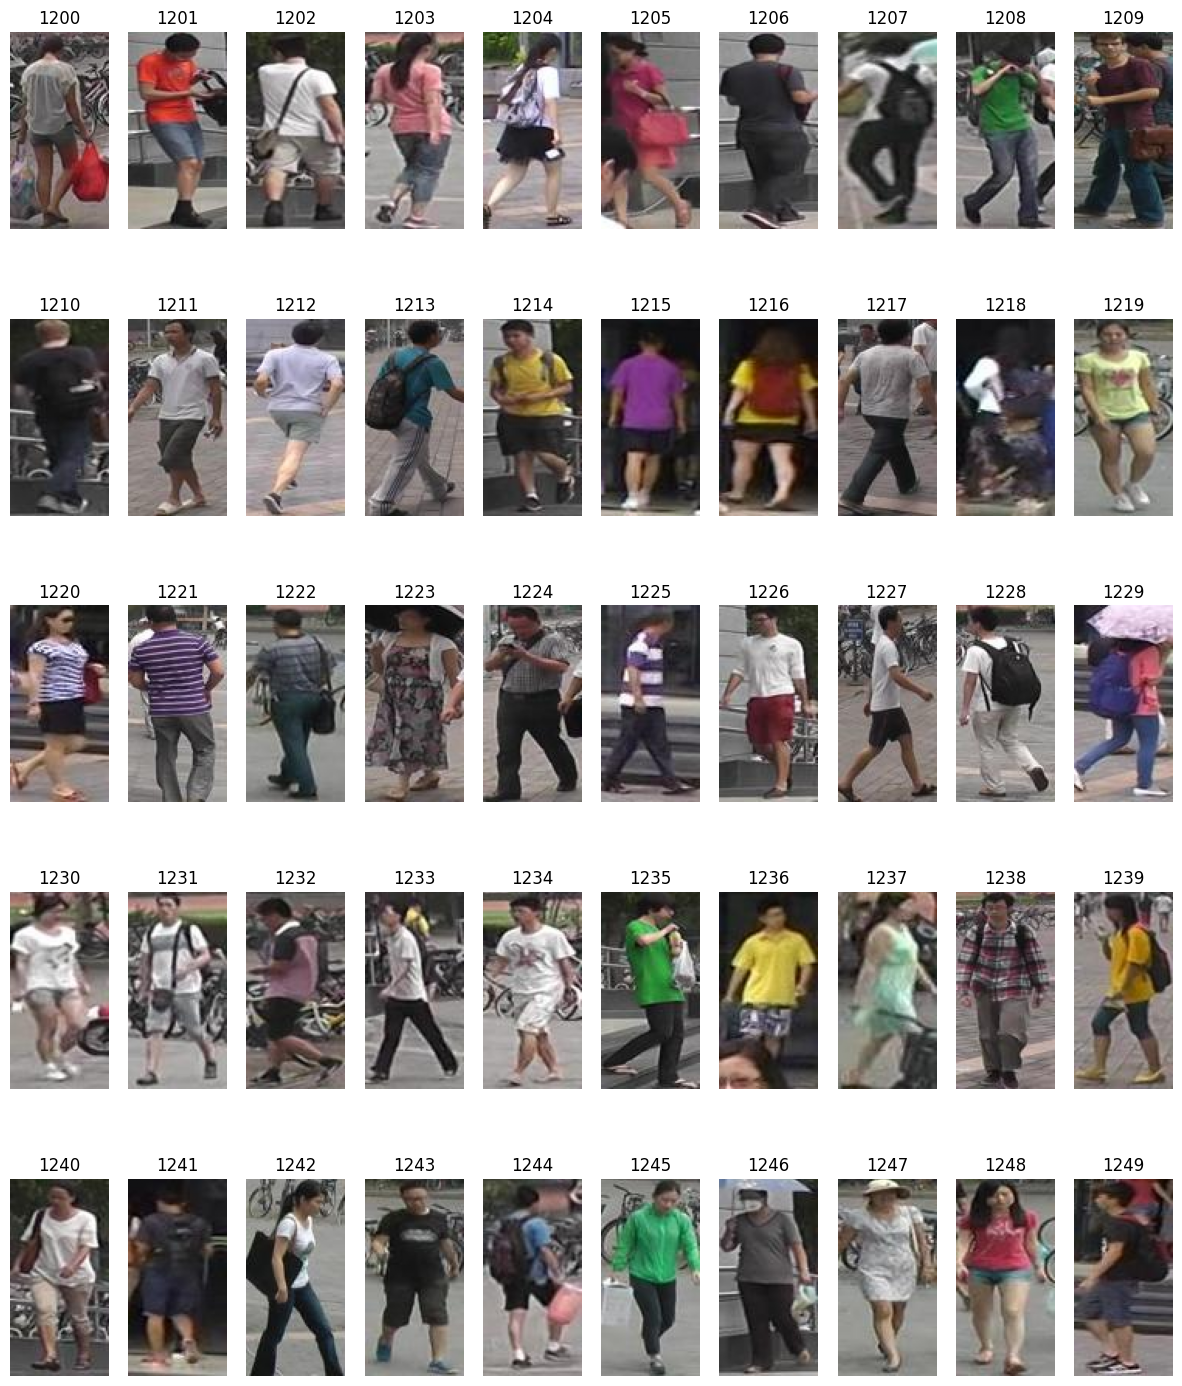

In [2]:
# note that you will probably need to change the filepath here
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Data/Q1/')
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot some images
plot_images(gallery_X, gallery_Y)

### Validation Gallery and Probe Sets

If you wish to use the validation set to simulate the test set and compute rank accuracies (or similar) to help select hyper-parameters, you will need to extract gallery and probe samples from the set. We can do this using the following.

Note that this will give us 50 samples in both sets, as we have 50 unique IDs and we're getting one sample per ID.

In [3]:
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

print(val_gallery_X.shape)
print(val_gallery_Y.shape)
print(val_probe_X.shape)
print(val_probe_Y.shape)

(50, 128, 64, 3)
(50,)
(50, 128, 64, 3)
(50,)


### Pair and Triplet Data

Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks. If you want pairs or triplets for the validation set, you would use the `val_X` and `val_Y` variables loaded by `load_data`

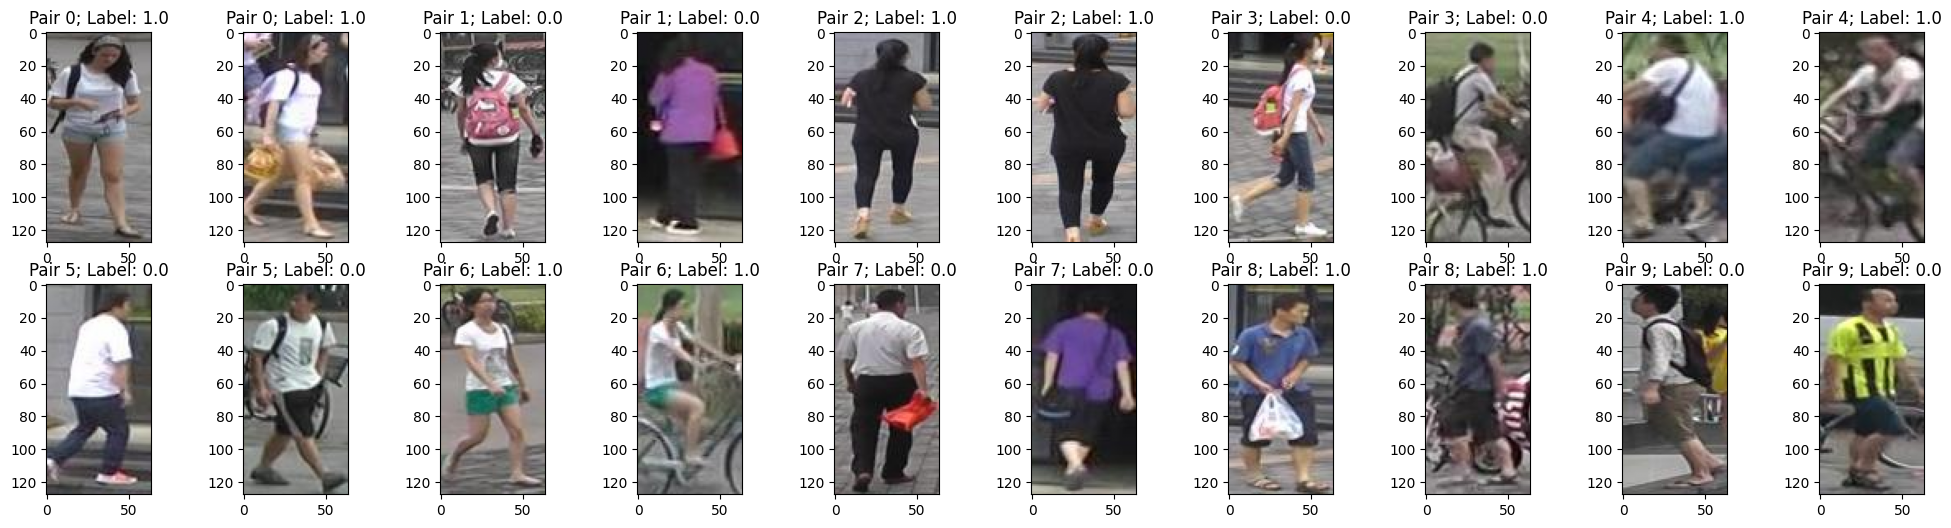

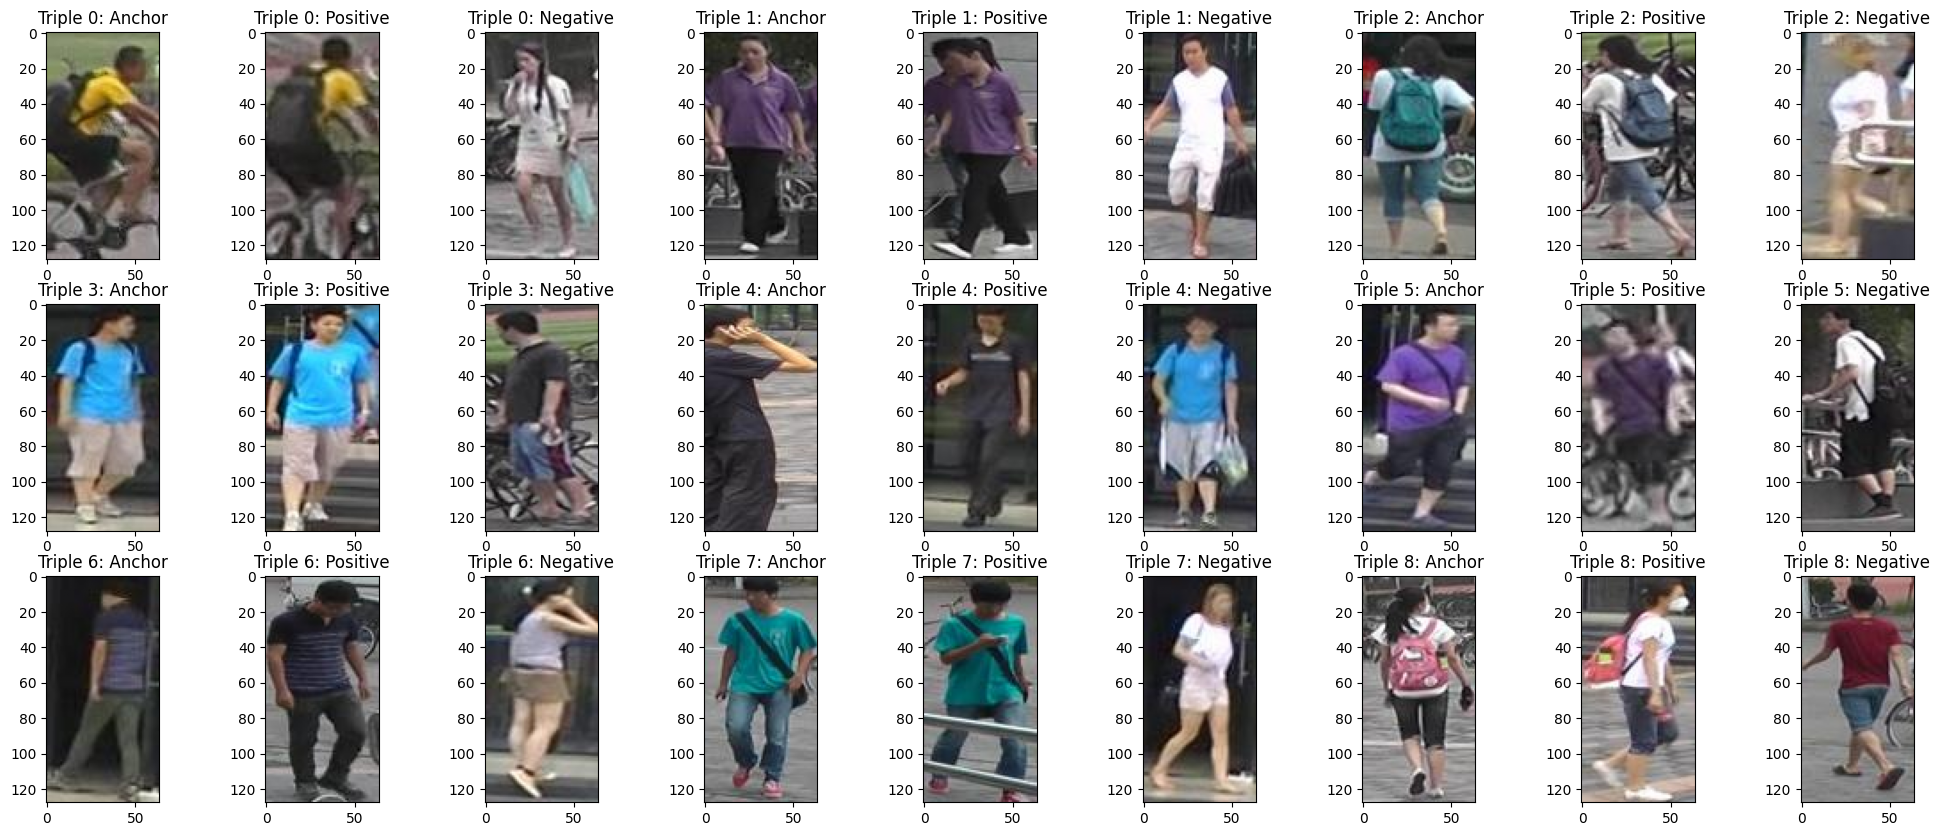

In [4]:
# create a pair generator and display a pair
x, y = get_siamese_data(train_X, train_Y, 10)
plot_pairs(x, y)

# create a triplet and display a triplet
x = get_triplet_data(train_X, train_Y, 9)
plot_triplets(x)

### Conversion and Resizing

Functions to convert images to greyscale and resize them are also provided.

I0000 00:00:1746394168.654164    1209 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


(301, 64, 32, 1)
(301, 64, 32, 1)


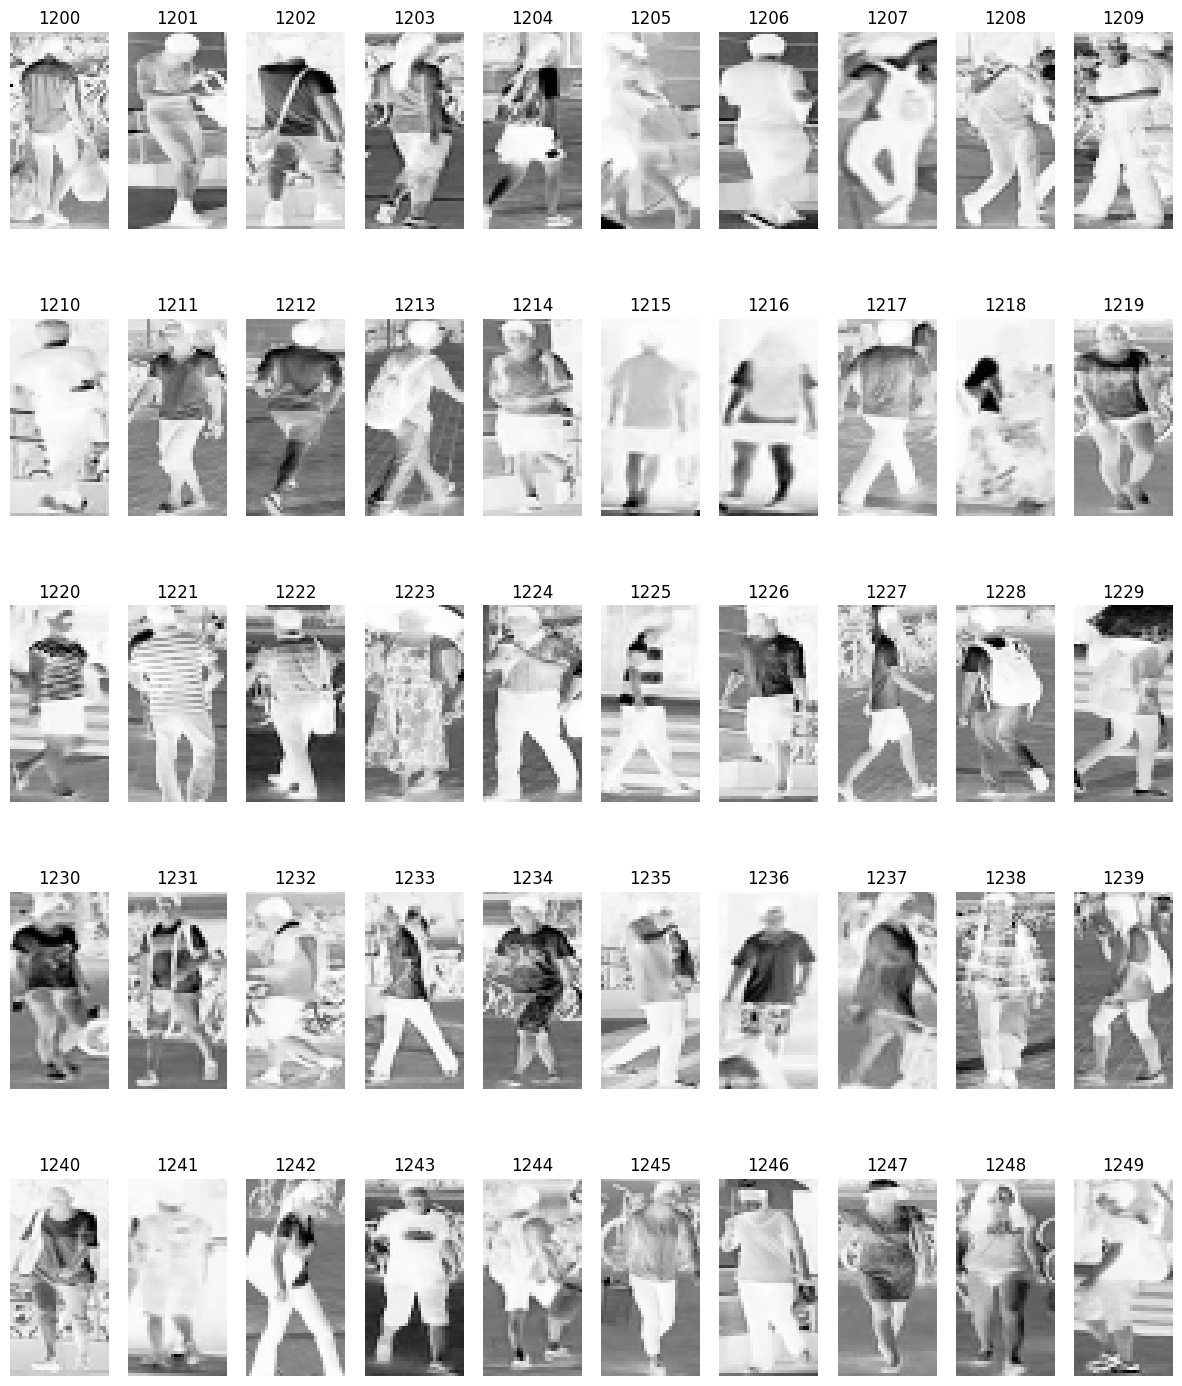

In [5]:
# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)

# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)

### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [6]:
# vectorise some data
gallery_feat_vec = vectorise(gallery_X_small_gray)
probe_feat_vec = vectorise(probe_X_small_gray)
print(gallery_feat_vec.shape)
print(probe_feat_vec.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
#

(301, 2048)
(301, 2048)


### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l2_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

[0 1 2 3 4 5 6 7]
[[ 0.29831068 -0.23375784]
 [-0.92346646  2.44918103]
 [ 2.45854016  0.22958071]
 [ 2.10172171  3.06316173]
 [ 2.40839323  2.3685806 ]
 [ 6.23552871  5.87682369]
 [ 6.57728831  7.20314875]
 [ 8.07654168  7.74635573]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[-0.98543246  3.01287613]
 [-2.98842466 -2.96333111]
 [ 1.64305408 -0.6736541 ]
 [ 4.52307023  5.41439961]
 [ 3.71453724  3.7811709 ]
 [ 2.33469132  5.27520269]
 [ 2.14643016  9.21056852]
 [10.90725417  5.12007461]]
(8, 2)
Searching for ID 0
[ 3.49122165  0.56709077  4.42805609  3.08756369  3.454442    7.76817069
  8.64598925 10.22375687]
Ranked IDs for query:
[1 3 4 0 2 5 6 7]
3

Searching for ID 1
[ 4.27237632  5.79304239  6.31380326  7.88848567  7.58649629 12.77613607
 13.9592327  15.39905427]
Ranked IDs for query:
[0 1 2 4 3 5 6 7]
1

Searching for ID 2
[ 1.41486519  4.04216859  1.21690208  3.7648597   3.13702662  7.99997391
  9.29465925 10.59652435]
Ranked IDs for query:
[2 0 4 3 1 5 6 7]
0

Searching for ID 3
[7.05338755 6.

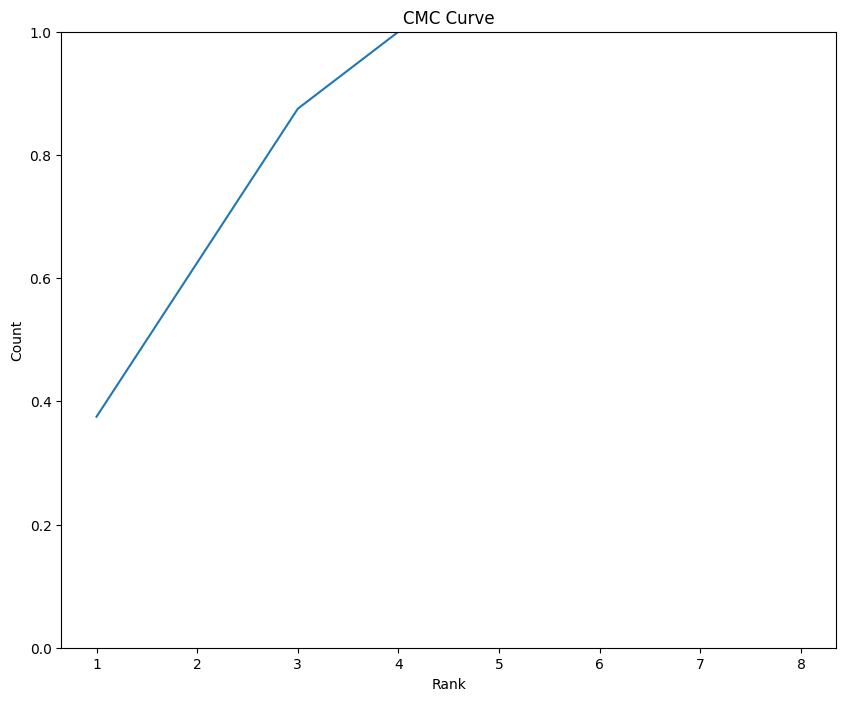

In [7]:
# we'll start off with just 8 IDs
num_ids = 8

# we'll create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# we'll then generate some features
# to keep this simple, we'll use a 2D feature, i.e. each sample will have a 2D feature associated with it
# this means that we have our gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# print features and their shape to confirm what we have
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# we can now compute the ranked histogram
# this will print out of a heap of debug data to show what's going on. In particular we see the distance between
# each probe sample and the whole gallery, and the rank of the true match, which is what is used to build the 
# ranked histogram
ranked_hist = get_ranked_histogram_l2_distance(Feat_1, ID_1, Feat_2, ID_2, True)
print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)

The above example results in a pretty simple CMC. Let's throw more IDs at it to get something that looks a bit better. The setup here is the same as what's above, we just have 100 gallery and probe samples now instead.

(100, 2)
(100, 2)


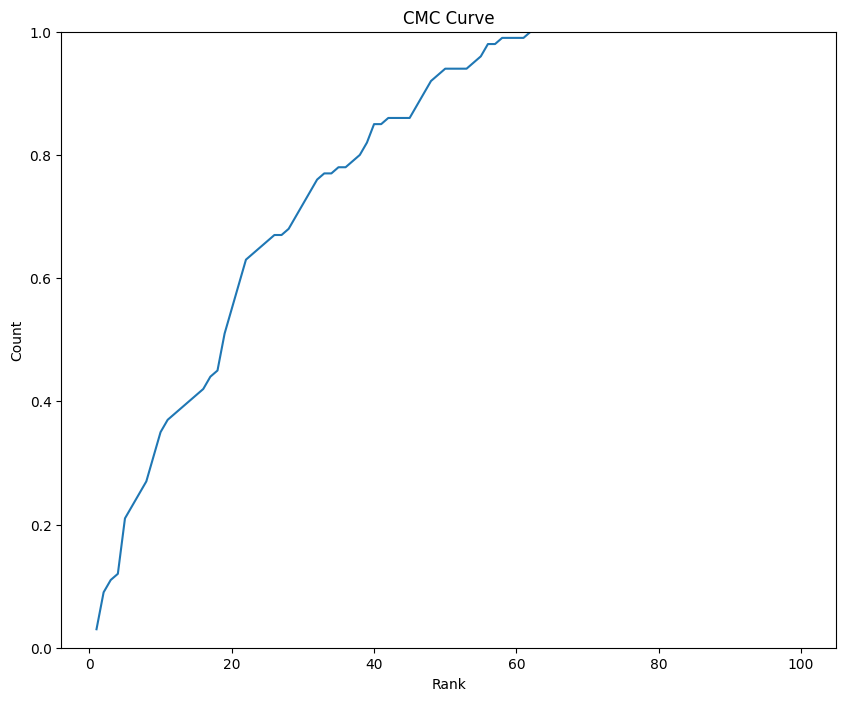

In [8]:
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l2_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

## Question 1 Template

The following provides a starting point for your solution, and some suggestions on how to proceed.

In [9]:
#
# Task Overview
#
# This question concerns person re-identification. We can think of this as a retrieval problem, where the input is an image
# and the output is a list of people, ranked based on how similar they are to the image. To get this similarity-based
# ranking, we need a way to compare two images and measure their similarity. To do this you will use a learned representation.
# The question asks you to train two models (one non-DL, one DL) to extract such a representation of an image. Using this
# learned representation, you can then transform a pair of images into vectors, and the distance between the vectors is a 
# measure of their similarity.
#
# The data you have been given is split into as follows: 
#  * training: Within the training set, you have roughly 2-20 images of 250 different people. You will use this data to train
#              your model. 
#  * validation: With the validation set, you have roughly 2-20 images of 50 different people. The 50 people here are totally
#                different from those in the training set. You will use this data is you want a validation set to train a 
#                deep net, or if you want a validation probe and gallery set to tune model hyper-parameters such as embedding
#                size or number of components to keep (note that what hyper-parameters you care about will depend on what
#                models you are using.
#  * testing: This itself is split into gallery and probe. The gallery and probe each contain one image for 301 individuals. 
#             The gallery and probe both contain the same 301 individuals. This is your test set. Note that the 301 individuals
#             here are again totally different from those in the training and validation sets. When thinking about this set, 
#             consider the re-ID problem. The gallery set contains images of 301 people that have been seen on some CCTV network. 
#             The probe set represents images that you are trying to match to those in the gallery set.
#

(4711, 64, 32, 1)
(1222, 64, 32, 1)
(301, 64, 32, 1)
(301, 64, 32, 1)


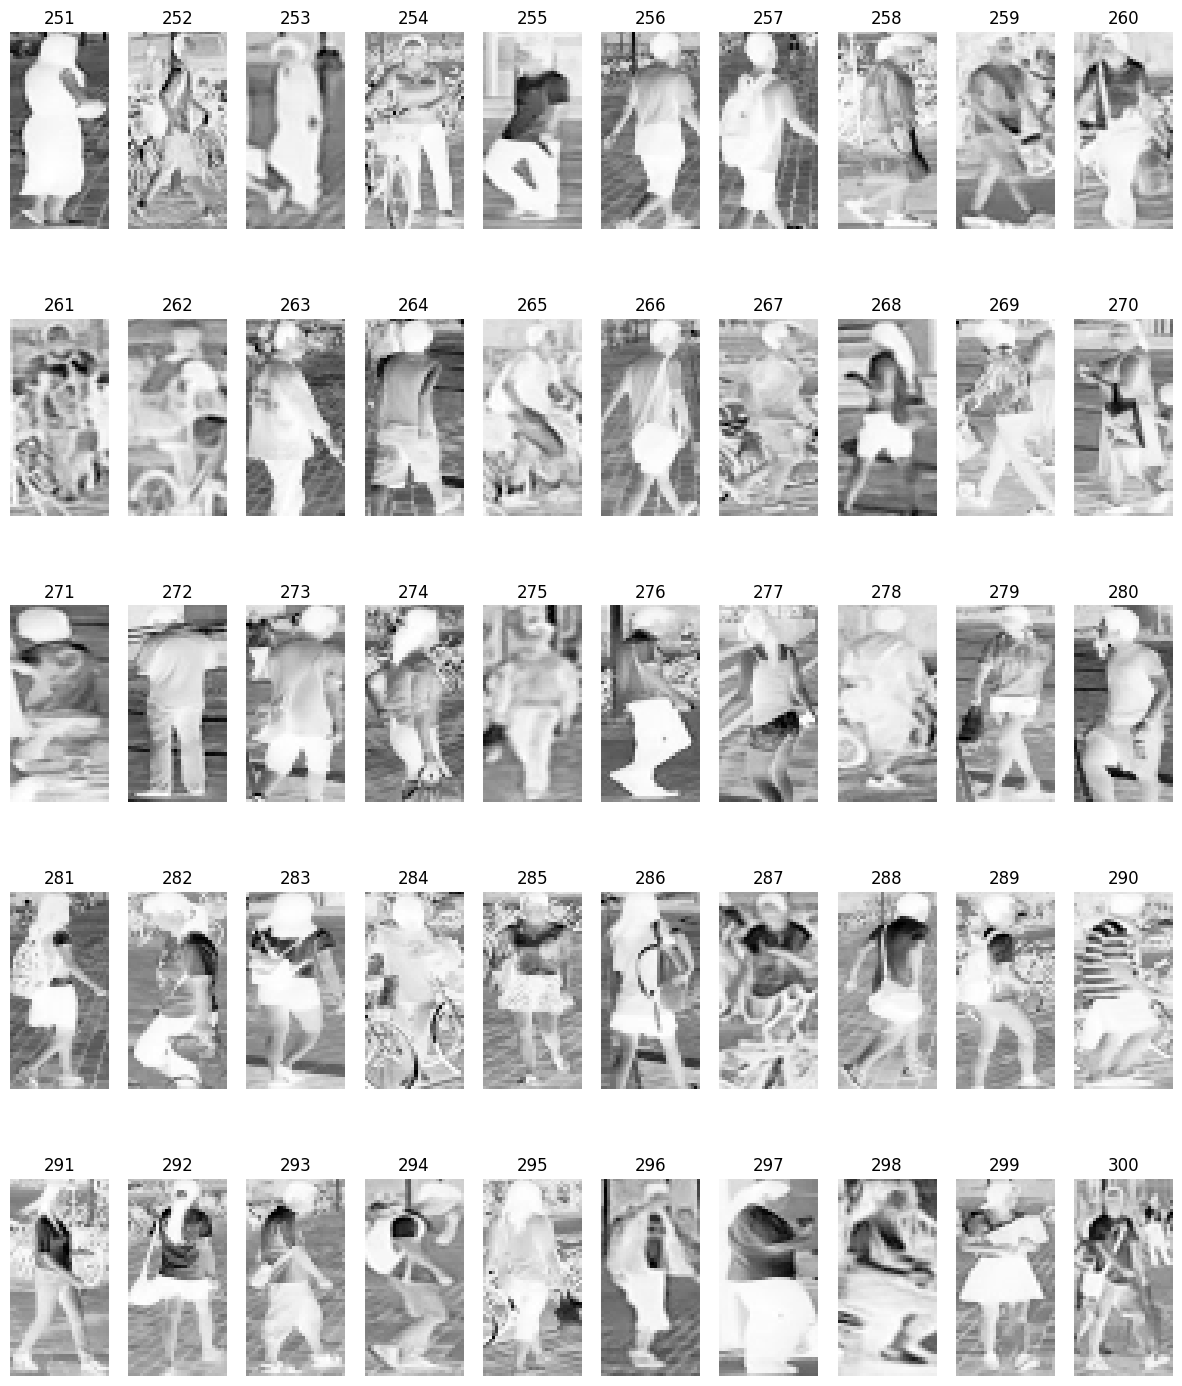

In [10]:
#
# Data loading and Pre-processing
#

# Load the data
# Change the path to whatever is appropriate on your system
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Data/Q1/')

# Pre-processing
# Do any resizing, colour conversion, etc, here. You can use the resize and convert_to_grayscale functions defined above. If
# you're keen, you could also look at other colour spaces - however this is not needed
#
# Note that you will do the same pre-processing to all datasets

# resize data and convert to grayscale

train_X = convert_to_grayscale(resize(train_X, (64, 32)))
print(train_X.shape)
val_X = convert_to_grayscale(resize(val_X, (64, 32)))
print(val_X.shape)
gallery_X = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X.shape)
probe_X = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X.shape)



# get validation gallery and probe sets, do this after the pre-processing to avoid double handling the data
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

# plot some resized and grayscale images
plot_images(val_gallery_X, val_gallery_Y)

# Create a vectorised version of the data
# You will need this to develop your non-deep learning method. We recommend that you do your vectorisation after you've
# done any pre-processing such that you are using the exact same data for both the non-DL and DL systems. 
#
# Note that the code below will vectorise the raw version of the data. If you have done any resizing, colour conversion, etc,
# change this to vectorise that version of the data
train_X_vec = vectorise(train_X)
val_X_vec = vectorise(val_X)
val_gallery_X_vec = vectorise(val_gallery_X)
val_probe_X_vec = vectorise(val_probe_X)
gallery_X_vec = vectorise(gallery_X)
probe_X_vec = vectorise(probe_X)

Non-DL Pipeline Runtime: 4.7202 seconds
Top-N Accuracies:
Top-1: 0.2800
Top-5: 0.5000
Top-10: 0.6000


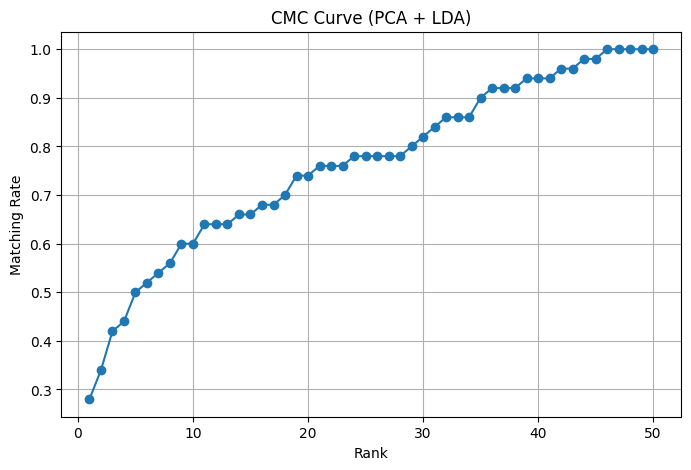

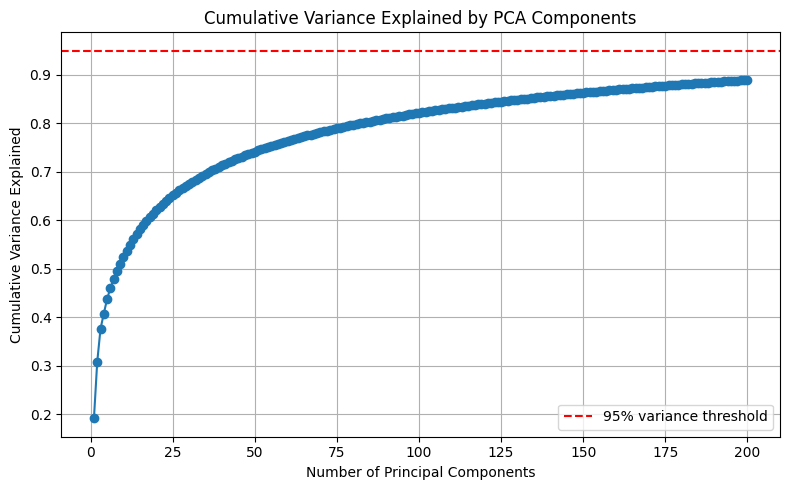

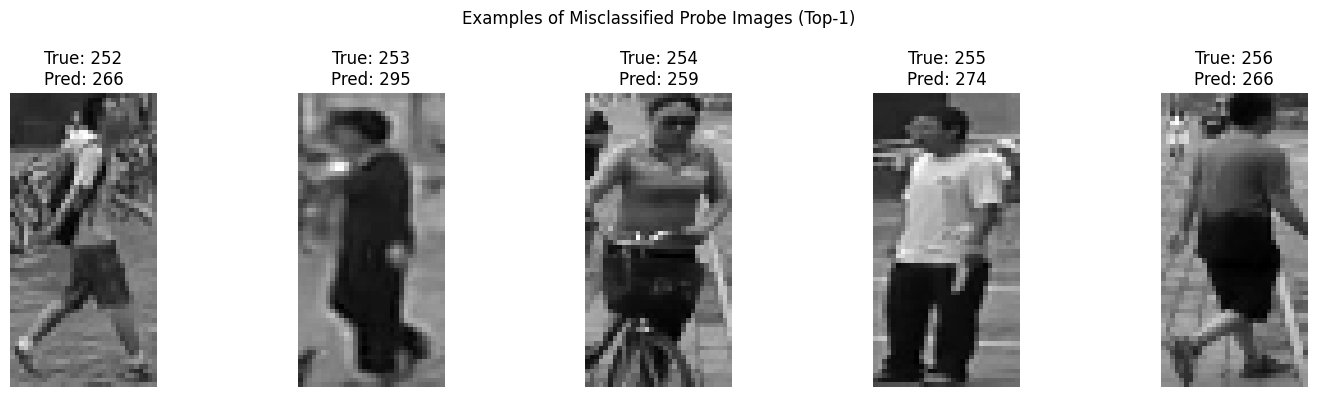

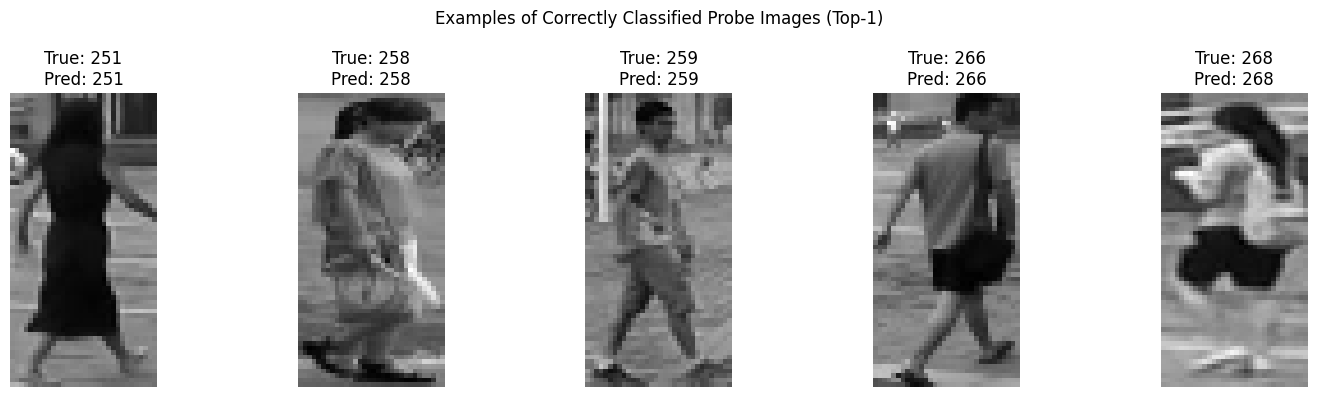

Top-N Accuracies (LDA + PCA):
Top-1: 0.2800
Top-5: 0.5000
Top-10: 0.6000


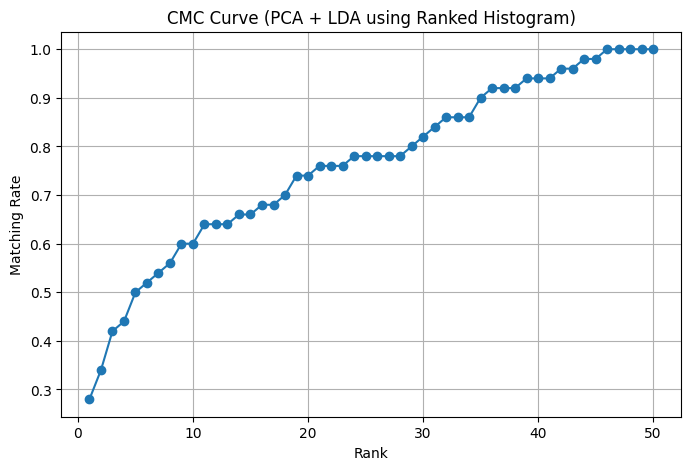

In [11]:
# 
# Non-DL Method
#
# Using the vectorised data, develop your non-DL method. A suggested approach would be:
# - Train a PCA, LDA, or both PDA and LDA subspace using the training data. Note that you will need to select the method(s), 
#   and choose any key parameters (for example, if you use PCA how many components you retain)
# - Using the trained subspace, project the gallery and probe data.
#
# If you wish to use the validation set:
#  - Use the val_gallery and val_probe sets to determine the transform to use / number of components to keep. You would compute
#    CMC curves / rank-1 accuracy for different options and pick the one that works best on the validation set (see below for
#    info on computing CMC curves, etc).
#


# Time the non-deep learning method
start = time.time()
# PCA: Reduce dimensionality before LDA
n_classes = len(np.unique(train_Y))
pca_components = min(train_X_vec.shape[0] - n_classes, 200)  # or use top-95% variance logic
pca = PCA(n_components=pca_components)
X_train_pca = pca.fit_transform(train_X_vec)
X_gallery_pca = pca.transform(val_gallery_X_vec)
X_probe_pca = pca.transform(val_probe_X_vec)

# LDA: Learn discriminative subspace
max_components = min(X_train_pca.shape[1], n_classes - 1)
lda = LDA(n_components=max_components)
X_train_lda = lda.fit_transform(X_train_pca, train_Y)
X_gallery_lda = lda.transform(X_gallery_pca)
X_probe_lda = lda.transform(X_probe_pca)
end = time.time()
print(f"Non-DL Pipeline Runtime: {end - start:.4f} seconds")
cmc_vals, topn = compute_cmc(X_probe_lda, val_probe_Y, X_gallery_lda, val_gallery_Y)

print("Top-N Accuracies:")
for k, v in topn.items():
    print(f"{k}: {v:.4f}")

# Plot CMC
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cmc_vals)+1), cmc_vals, marker='o')
plt.title("CMC Curve (PCA + LDA)")
plt.xlabel("Rank")
plt.ylabel("Matching Rate")
plt.grid(True)
plt.show()

# PCA Variance Plot

# Plot cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% variance threshold')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Predict Top-1 matches using 1-NN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_gallery_lda, val_gallery_Y)
top1_preds = knn.predict(X_probe_lda)

# Misidentified images
# Identify misclassified probe samples
incorrect_indices = np.where(top1_preds != val_probe_Y)[0]

# Plot a few misclassified probe images with their incorrect predicted labels
num_to_show = min(5, len(incorrect_indices))  # Show up to 5
plt.figure(figsize=(15, 4))
for idx, i in enumerate(incorrect_indices[:num_to_show]):
    plt.subplot(1, num_to_show, idx + 1)
    img = val_probe_X[i]  # Original grayscale image (not vectorised)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {val_probe_Y[i]}\nPred: {top1_preds[i]}")
    plt.axis('off')
plt.suptitle("Examples of Misclassified Probe Images (Top-1)")
plt.tight_layout()
plt.show()

# Correctly classified images
correct_indices = np.where(top1_preds == val_probe_Y)[0]

# Plot a few correctly classified probe images with their predicted labels
num_to_show = min(5, len(correct_indices))  # Show up to 5
plt.figure(figsize=(15, 4))
for idx, i in enumerate(correct_indices[:num_to_show]):
    plt.subplot(1, num_to_show, idx + 1)
    img = val_probe_X[i]  # Original grayscale image (not vectorised)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {val_probe_Y[i]}\nPred: {top1_preds[i]}")
    plt.axis('off')
plt.suptitle("Examples of Correctly Classified Probe Images (Top-1)")
plt.tight_layout()
plt.show()

# Step 1: Run PCA + LDA like before
# (Already in your code)

# Step 2: Use the ranked histogram + CMC functions
ranked_hist = get_ranked_histogram_l2_distance(
    gallery_feat=X_gallery_lda,
    gallery_Y=val_gallery_Y,
    probe_feat=X_probe_lda,
    probe_Y=val_probe_Y,
    verbose=False
)

cmc_vals = ranked_hist_to_CMC(ranked_hist)

# Step 3: Compute Top-N Accuracies (same as CMC at rank-1, rank-5, rank-10)
topn = {
    "Top-1": cmc_vals[0],
    "Top-5": cmc_vals[4] if len(cmc_vals) > 4 else cmc_vals[-1],
    "Top-10": cmc_vals[9] if len(cmc_vals) > 9 else cmc_vals[-1]
}

# Step 4: Print results
print("Top-N Accuracies (LDA + PCA):")
for k, v in topn.items():
    print(f"{k}: {v:.4f}")

# Step 5: Plot CMC Curve
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cmc_vals)+1), cmc_vals, marker='o')
plt.title("CMC Curve (PCA + LDA using Ranked Histogram)")
plt.xlabel("Rank")
plt.ylabel("Matching Rate")
plt.grid(True)
plt.show()

In [12]:
#
# DL Method
# 
# Using the image data, develop your DL method. A suggested approach would be:
#  - Pick a backbone for your network. This could be a network from the lecture or prac examples, or something from
#    keras.applications. As per Assignment 1A, the network does not need to be overly complex, but you should briefly explain 
#    your selection of this model. You should avoid networks so simple that they perform very badly.
#  - Pick your training approach. You have been given pair and triplet creation functions above, so you can easily use either contrastive
#    or a triplet loss. You could also look at the bonus example on hard negative mining and consider this approach. Once you've
#    picked your approach, set the network up with the correct number of inputs and an appropriate loss.
#  - Create some pairs and triplets, and train the network using the training set
#
# If you wish to use the validation set:
#  - Use the val_X and val_Y set with your pair/triplet/whatever function to determine when your model has converged
#  - Use the val_gallery and val_probe sets to determine other network parameters such as embedding sizes. You would compute
#    CMC curves / rank-1 accuracy for different options and pick the one that works best on the validation set (see below for
#    info on computing CMC curves, etc).
#

# Compile the model
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Subtract

def contrastive_loss(y_true, y_pred, margin=1.0):
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

#doy Encoder part
#def build_encoder(input_shape):
#    inputs = layers.Input(shape=input_shape)
#    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#    x = layers.MaxPooling2D((2, 2))(x)
#    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = layers.MaxPooling2D((2, 2))(x)
#    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#    x = layers.MaxPooling2D((2, 2))(x)
#    x = layers.Flatten()(x)
#    x = layers.Dense(128, activation='relu')(x)
#    encoder = models.Model(inputs, x)
#    return encoder
from tensorflow.keras import layers, models, Input

def residual_block(x, filters, downsample=False):
    identity = x

    stride = 2 if downsample else 1
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, (1, 1), strides=2, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x
def build_resnet18_encoder(input_shape=(64, 32, 1), embedding_dim=128):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(embedding_dim)(x)

    model = models.Model(inputs, x, name="ResNet18_Encoder")
    return model

def build_encoder(input_shape):
    base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    encoder = models.Model(inputs=base_model.input, outputs=x, name="resnet_encoder")
    return encoder

# Siamese network part
def siamese_network(input_shape):
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Encoder
    encoder = build_encoder(input_shape)
    
    # Encode both inputs
    encoded_a = encoder(input_a)
    encoded_b = encoder(input_b)
    
    # Compute the absolute difference between the encoded outputs
    diff = layers.Subtract()([encoded_a, encoded_b])
    distance = layers.Lambda(lambda x: K.abs(x))(diff)
    
    # Flatten the distance tensor before passing to the dense layer
    #distance = layers.Flatten()(distance)
    
    # Dense layer for classification (same or different)
    x = layers.Dense(128, activation='relu')(distance)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[input_a, input_b], outputs=output)
    return model

# Build the encoder
# encoder = build_encoder(train_X.shape[1:])
encoder = build_resnet18_encoder(train_X.shape[1:], embedding_dim=128)

# Define the Siamese Network model
model = siamese_network(train_X.shape[1:])
model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])

# Get the Siamese data for training
train_pairs, train_labels = get_siamese_data(train_X, train_Y, batch_size=1024)
val_pairs, val_labels = get_siamese_data(val_X, val_Y, batch_size=1024)

# Train the model
start_time = time.time()
model.fit(
    [train_pairs[0], train_pairs[1]], train_labels,
    validation_data=([val_pairs[0], val_pairs[1]], val_labels),
    batch_size=32,
    epochs=40
)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training time: {elapsed_time:.2f} seconds")

print(f"Number of training pairs: {len(train_labels)}")
print(f"Train pair shape: {train_pairs[0].shape}")
print(f"Train labels shape: {train_labels.shape}")

Epoch 1/40


I0000 00:00:1746394232.978562    1283 service.cc:152] XLA service 0x7fa44c002470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746394232.978592    1283 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1746394238.735281    1283 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/32 ━━━━━━━━━━━━━━━━━━━━ 27:49 54s/step - accuracy: 0.4688 - loss: 0.2884

I0000 00:00:1746394261.946423    1283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.4871 - loss: 0.3150 - val_accuracy: 0.5000 - val_loss: 0.2501
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3868 - loss: 0.2600 - val_accuracy: 0.5000 - val_loss: 0.2506
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3438 - loss: 0.2358 - val_accuracy: 0.5000 - val_loss: 0.2512
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.4252 - loss: 0.2776 - val_accuracy: 0.5000 - val_loss: 0.2513
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.3846 - loss: 0.2480 - val_accuracy: 0.4883 - val_loss: 0.2488
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3632 - loss: 0.2478 - val_accuracy: 0.4141 - val_loss: 0.2403
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3258 - loss: 0.2234 - val_accuracy: 0.4189 - val_loss: 0.2403
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.2747 - loss: 0.1955 - val_accuracy: 0.3936 - val

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top-1 Accuracy:  0.320
Top-5 Accuracy:  0.600
Top-10 Accuracy: 0.700


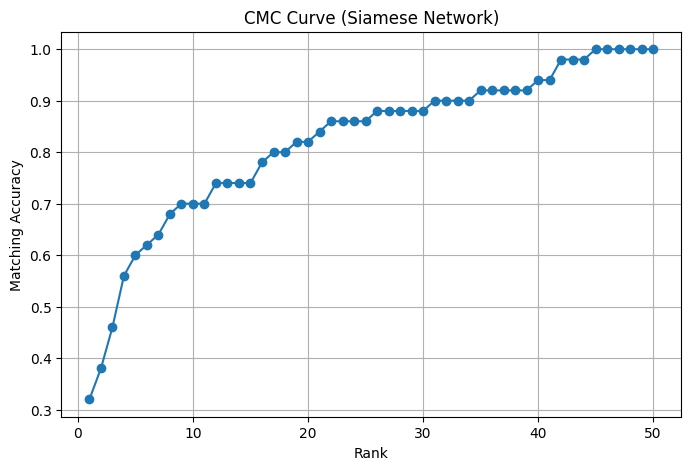

Gallery size: 50
Probe size: 50


In [16]:
gallery_X = val_gallery_X
gallery_Y = val_gallery_Y
probe_X = val_probe_X
probe_Y = val_probe_Y
# --- Get embeddings ---
gallery_embeddings = encoder.predict(gallery_X, batch_size=32)
probe_embeddings = encoder.predict(probe_X, batch_size=32)

from sklearn.metrics.pairwise import euclidean_distances

# Distance matrix (num_probes × num_gallery)
dists = euclidean_distances(probe_embeddings, gallery_embeddings)
ranked_gallery_indices = np.argsort(dists, axis=1)

def compute_top_k_accuracy(ranked_indices, gallery_Y, probe_Y, k):
    correct = 0
    for i in range(len(probe_Y)):
        top_k = gallery_Y[ranked_indices[i][:k]]
        if probe_Y[i] in top_k:
            correct += 1
    return correct / len(probe_Y)

top1 = compute_top_k_accuracy(ranked_gallery_indices, gallery_Y, probe_Y, 1)
top5 = compute_top_k_accuracy(ranked_gallery_indices, gallery_Y, probe_Y, 5)
top10 = compute_top_k_accuracy(ranked_gallery_indices, gallery_Y, probe_Y, 10)

print(f"Top-1 Accuracy:  {top1:.3f}")
print(f"Top-5 Accuracy:  {top5:.3f}")
print(f"Top-10 Accuracy: {top10:.3f}")


import matplotlib.pyplot as plt


max_rank = len(gallery_Y)  # e.g. 50
cmc = [compute_top_k_accuracy(ranked_gallery_indices, gallery_Y, probe_Y, k) for k in range(1, max_rank + 1)]

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_rank + 1), cmc, marker='o')
plt.title('CMC Curve (Siamese Network)')
plt.xlabel('Rank')
plt.ylabel('Matching Accuracy')
plt.grid(True)
plt.show()
print("Gallery size:", len(gallery_Y))  # or val_gallery_Y
print("Probe size:", len(probe_Y))

In [14]:
# 
# Evaluation
# 
# You will now evaluate your methods using the CMC curve and rank-1, -5 and -10 accuracies. The functions provided above will allow
# you to obtain these values. To do this you will use code that is something like the following:
#
# gallery_feats = model.transform(gallery_X)
# probe_feats = model.transform(probe_X)
# ranked_hist = get_ranked_histogram_l2_distance(gallery_feats, gallery_Y, probe_feats, probe_Y)
# cmc = ranked_hist_to_CMC(ranked_hist)
# rank_1_acc = cmc[0]
# rank_5_acc = cmc[4]
# rank_10_acc = cmc[9]
# plot_cmc(cmc)
#
# In the above, the model.transform operation will be replaced with whatever is appropriate for what you have done. For the non-DL
# method, this is likely to be fairly similar. For the DL method, you will likely change this to call the predict function on your
# backbone network. Your input data (gallery_X and probe_X) will also change to any resized, colour converted and/or vectorised
# version you are using.
#
# The cmc variable that results from the call to ranked_hist_to_CMC will give you the rank-1, -5 and -10 accuracies directly, and
# is what you will plot to visualise performance. Note that you may wish to plot the CMCs for both models on the same axis to make
# it easier to compare performance.
# 

In [15]:
# For your write-up, you should include:
# - briefly mention any pre-processing you did and why; or why you left the data as-is. Note that for fair comparison, 
#   use the same pre-processing for both the methods (non-deep learning and deep-learning) is recommended. If you split 
#   the data into training and validation sets you could dicsuss this here too
# - Outline your methods. For both the non-DL and DL methods, outline what you did and why, and any key parameters you
#   set. For the DL method, outline how it was trained.
# - An evaluation, that covers the Rank-1, -5 and -10 results, and the CMC curves. Consider where performance differs
#   between the models, and the pros and cons of each.
# - A brief discsusion of the ethical considerations as they relate to person re-id (see the assignment brief for 
#   further details and references to use as a starting point
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions.
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT